# Merging Data to Understand the Relationship between Drug Legalization and Violent Crime



In recent years, many US states have decided to legalize the use of marijuana. 

When these ideas were first proposed, there were many theories about the relationship between crime and the "War on Drugs" (the term given to US efforts to arrest drug users and dealers over the past several decades). 

In this exercise, we're going to test a few of those theories using drug arrest data from the state of California. 

Though California has passed a number of laws lessening penalities for marijuana possession over the years, arguably the biggest changes were in  2010, when the state changed the penalty for possessing a small amount of marijuana from a criminal crime to a "civil" penality (meaning those found guilty only had to pay a fine, not go to jail), though possessing, selling, or producing larger quantities remained illegal. Then in 2016, the state fully legalized marijuana for recreational use, not only making possession of small amounts legal, but also creating a regulatory system for producing marijuana for sale. 

Proponents of drug legalization have long argued that the war on drugs contributes to violent crime by creating an opportunity for drug dealers and organized crime to sell and distribute drugs, a business which tends to generate violence when gangs battle over territory. According to this theory, with drug legalization, we should see violent crime decrease after legalization in places where drug arrests had previously been common. 

**To be clear,** this is far from the only argument for drug legalization! It is simply the argument we are well positioned to analyze today. 


## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_merging.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex6_merge_type",
    "ex10_merged_successfully",
    "ex16_num_obs",
    "ex17_drug_change",
    "ex18_violent_change",
    "ex21_diffindiff",
    "ex23_diffindiff_proportionate",
}
```


### Submission Limits

Please remember that you are **only allowed three submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.

## Pre-Legalization Analysis

### Exercise 1
We will begin by examining [county-level data on arrests from California in 2009](https://github.com/nickeubank/practicaldatascience/tree/master/Example_Data/ca). This data is derived directly from data hosted by the [Office of the California State Attorney General](https://openjustice.doj.ca.gov/data), but please follow the github link above and download and import the file `ca_arrests_2009.csv` (don't try and get it directly from the State Attorney General's office). 

In [68]:
# Loading the arrest 2009 California dataset and loading necessary libraries. Initializing the results dictionary.
results = {}
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

arrest_df = pd.read_csv(
    "https://github.com/nickeubank/practicaldatascience/raw/master/Example_Data/ca/ca_arrests_2009.csv",
    index_col=0,
)

arrest_df.head()

,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
1682,Alameda County,4318,4640,5749,260,3502,18469,37247,431
1683,Alpine County,8,4,2,1,1,16,83,0
1684,Amador County,100,59,101,5,199,464,801,2
1685,Butte County,641,602,542,34,429,2248,9026,1
1686,Calaveras County,211,83,123,14,70,501,968,3


### Exercise 2
Use your data exploration skills to get a feel for this data. If you need to, you can find the [original codebook here](https://github.com/nickeubank/practicaldatascience/blob/master/Example_Data/ca/arrests_codebook.pdf) (This data is a version of that data, but collapsed to one observation per county.)

### Exercise 3
Figuring out what county has the most violent arrests isn't very meaningful if we don't normalize for size. A county with 10 people and 10 arrests for violent crimes is obviously worse than a county with 1,000,000 people an 11 arrests for violent crime. 

To address this, also import `nhgis_county_populations.csv` from [the directory we're working from](https://github.com/nickeubank/practicaldatascience/tree/master/Example_Data/ca).

In [69]:
nhgis_df = pd.read_csv(
    "https://github.com/nickeubank/practicaldatascience/raw/master/Example_Data/ca/nhgis_county_populations.csv",
    index_col=0,
)

print(nhgis_df.head())

nhgis_df_cali = nhgis_df.loc[nhgis_df["STATE"] == "California", :]

nhgis_df_cali_year = nhgis_df_cali[nhgis_df_cali["YEAR"] == "2005-2009"]

print(nhgis_df_cali_year.head())

        YEAR    STATE          COUNTY  total_population
0  2005-2009  Alabama  Autauga County             49584
1  2005-2009  Alabama  Baldwin County            171997
2  2005-2009  Alabama  Barbour County             29663
3  2005-2009  Alabama     Bibb County             21464
4  2005-2009  Alabama   Blount County             56804
          YEAR       STATE            COUNTY  total_population
186  2005-2009  California    Alameda County           1457095
187  2005-2009  California     Alpine County              1153
188  2005-2009  California     Amador County             38039
189  2005-2009  California      Butte County            217917
190  2005-2009  California  Calaveras County             46548


### Exercise 4
Use your data exploration skills to get used to this data, and figure out how it relates to your 2009 arrest data. 

#### These are the desciptions for each variable in our data
- F_drugoff: is the sum of arrest for felony drug offenses(narcotics, marijuana, etc.)
- F_sexoff : sum of arrest for felony sex offense(lewd, unlawful sexual intercourse)
- F_allother: sum of arrest for all other felony offenses
- M_Total: Sum of all misdemeanor arrests
- S_Total: Sum of all arrests for status offenses
- Property: Sum of arrests for felony property offenses(burglary, theft, motor vehicle theft,etc)
- Violent: Sum of arrests for felony violent offenses(homicide, assault, kidnapping)
- County: County of reporting agency

#### How does nhgis_county_populations.csv data related to 2009 arrest data
In our nhgis_county population data, we can see information for all 50 states in the United States and their total population size. We can see in the 2009 arrest data, we are only looking at arrests in California. We will need to only select from nhgis_county_populations data the state California and the Total population from California. Once, this information is extracted we can merge it with the 2009 arrest data. 

### Exercise 5

Once you feel like you have a good sense of the relation between our arrest and population data, merge the two datasets.

In [70]:
merged_df = pd.merge(arrest_df, nhgis_df_cali_year, how="left", on="COUNTY")

merged_df.reset_index(drop=True, inplace=True)

merged_df.head()

,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,YEAR,STATE,total_population
0,Alameda County,4318,4640,5749,260,3502,18469,37247,431,2005-2009,California,1457095.0
1,Alpine County,8,4,2,1,1,16,83,0,2005-2009,California,1153.0
2,Amador County,100,59,101,5,199,464,801,2,2005-2009,California,38039.0
3,Butte County,641,602,542,34,429,2248,9026,1,2005-2009,California,217917.0
4,Calaveras County,211,83,123,14,70,501,968,3,2005-2009,California,46548.0


### Exercise 6

When merging data, the result will only be meaningful if your understanding of how the data sets you are merging relate to one another are correct. In some ways, this is obvious — for example, if the variable(s) that you are using to merge observations in the two datasets or to actually identifying observations that should be linked, then obviously merging using those variables will create a meaningless new dataset.

But other properties that matter are often more subtle. For example, it's important to figure out whether your merge is a `1-to-1` merge (meaning there is only one observation of the variable you're merging on in both datasets), a `1-to-many` merge (meaning there is only one observation of the variable you're merging on in the first dataset, but multiple observations in the second), or a `many-to-many` merge (something you almost never do). 

Being correct in your assumptions about these things is *very* important. If you think there's only one observation per value of your merging variable in each dataset, but there are in fact 2, you'll end up with two observations for each value after the merge. Moreover, not only is the structure of your data now a mess, but the fact you were wrong means you didn't understand something about your data. 

So before running a merge, it is critical to answer the following questions:

a) What variable(s) do you think will be consistent across these two datasets you can use for merging? 


b) Do you think there will be exactly 1 observation for each value of this variable(s) in your arrest data?


c) Do you think there will be exactly 1 observation for each value of this variable(s) in your population data?


So in markdown, answer these three questions for this data.




Then also specify the type of merge you were hoping to accomplish as one of the following strings — `"one-to-one"`, `"one-to-many"`, `"many-to-one"`, or `"many-to-many"` — in your `results` dictionary under the key `"ex6_validate_keyword"`. Assume that the first dataset we are talking about (e.g., the `one` in `one-to-many`, if that were your selection) is your arrests data and the second dataset (e.g., the `many` in `one-to-many`, if that were your selection).

In [71]:
# Exercise 6 : Deciding the merge method
results["ex6_validate_keyword"] = "one=to-many"

#### Exercise 6
a) What variable(s) do you think will be consistent across these two datasets you can use for merging? 
    - Counties from the state of California are the only consist variables.

b) Do you think there will be exactly 1 observation for each value of this variable(s) in your arrest data?
    - Yes, I think for each county there is only one set of observations for each column within the arrest data. 

c) Do you think there will be exactly 1 observation for each value of this variable(s) in your population data?
- Within, the population data there are 2 observations the county variable. This is because the population data looks at two sets of time frames (2005-2009 and 2013-2017).

So in markdown, answer these three questions for this data.

## Merge Validation

Because of the importance of answering these questions accurately, `pandas` provides a utility for *validating* these assumptions when you do a merge: the `validate` keyword! Validate will accept `"1:1"`, `"1:m"`, `"m:1"`, and `"m:m"`. It will then check to make sure your merge matches the type of merge you think it is. I *highly* recommend always using this option (...and not just because I'm the one who added `validate` to pandas).

*Note:* `validate` only actually tests if observations are unique when a `1` is specified; if you do a `1:1` merge but pass `validate="1:m"`, `validate="m:1"`, or `validate="m:m"`, you won't get an error — a one-to-many merge that turns out to be a one-to-one isn't nearly as dangerous as a one-to-one merge that turns out to be one-to-many.

### Exercise 7

Repeat the merge you conducted above, but this time use the `validate` to make sure your assumptions about the data were correct. If you find that you made a mistake, revise your data until the merge you think is correct actually takes place.

To aid the autograder, please make sure to comment out any code that generates an error.



In [72]:
validation_df = pd.merge(arrest_df, nhgis_df, on="COUNTY", validate="1:m")

### Exercise 8

Were your assumptions about the data correct? If not, what had you (implicitly) assumed when you did your merge in Exercise 5 that turned out not to be correct?

#Exercise 8: Were your assumptions correct?
My assumption about the data was correct because I throughly looked at the data and checked different years as conditions. I implicity though I could merge the data and didn't realize that the arrest data was just for 2009 and population has two time periods. 

## Merge Diagnostics

### Exercise 9

Checking whether you are doing a 1-to-1, many-to-1, 1-to-many, or many-to-many merge is only the first type of diagnostic test you should run on *every* merge you conduct. The second test is to see if you data merged successfully!

To help with this, the `merge` function in pandas offers a keyword option called `indicator`. If you set `indicator` to `True`, then pandas will add a column to the result of your merge called `_merge`. This variable will tell you, for each observation in your merged data, whether: 

- that observation came from a successful merge of both datasets, 
- if that observation was in the left dataset (the first one you passed) but not the right dataset (the second one you passed), or 
- if that observation was in the right dataset but not the left. 

This allows you to quickly identify failed merges!

For example, suppose you had the following data:

In [73]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

df1 = pd.DataFrame({"key": ["key1", "key2"], "df1_var": [1, 2]})
df1

,key,df1_var
0,key1,1
1,key2,2


In [74]:
df2 = pd.DataFrame({"key": ["key1", "Key2"], "df2_var": ["a", "b"]})
df2

,key,df2_var
0,key1,a
1,Key2,b


Now suppose you *expected* that all observations should merge when you merge these datasets (because you hadn't noticed the typo in `df2` where `key2` has a capital `Key2`. If you just run a merge, it works without any problems:

In [75]:
new_data = pd.merge(df1, df2, on="key", how="outer")

And so you might carry on in life unaware your data is now corrupted: instead of two merged rows, you now have 3, only 1 of which merged correctly!

In [76]:
new_data

,key,df1_var,df2_var
0,key1,1.0,a
1,key2,2.0,NaN
2,Key2,NaN,b


When what you really wanted was: 

In [77]:
df2_correct = df2.copy()
df2_correct.loc[df2.key == "Key2", "key"] = "key2"
pd.merge(df1, df2_correct, on="key", how="outer")

,key,df1_var,df2_var
0,key1,1,a
1,key2,2,b


(in a small dataset, you'd quickly see you have 1 row instead of 2, but if you have millions of rows, a couple missing won't be evident). 

But now suppose we use the `indicator` function:

In [78]:
new_data = pd.merge(df1, df2, on="key", how="outer", indicator=True)
new_data._merge.value_counts()

_merge
left_only     1
right_only    1
both          1
Name: count, dtype: int64

We could immediately see that only one observation merged correct, and that one row from each dataset failed to merge!

Moreover, we can look at the failed merges:

In [79]:
new_data[new_data._merge != "both"]

,key,df1_var,df2_var,_merge
1,key2,2.0,NaN,left_only
2,Key2,NaN,b,right_only


Allowing us to easily diagnose the problem. 

**Note:** The `pandas` merge function allows users to decide whether to keep only observations that merge (`how='inner'`), all the observations from the first dataset pasted to merge (`how='left'`), all the observations from the second dataset passed to merge (`how='right'`), or all observations (`how='outer'`):

![join_types](https://nickeubank.github.io/practicaldatascience_book/_images/3.4.15_merge_types.png)

But one danger to using the more restrictive options (like the default, `how='inner'`) is that the merge throws away all the observations that fail to merge, and while this may be the *eventual* goal of your analysis, it means that you don't get to see all the observations that failed to merge that maybe you thought *would* merge. In other words, it throws away the errors so you can't look at them!  

So to use `indicator` effectively, you have to:

- Not use `how="inner"`, and
- Check the values of `_merge` after your merge. 

### Exercise 10

Now repeat your previous merge using *both* the `validate` keyword *and* the `indicator` keyword with `how='outer'`. 

How many observations successfully merged (were in both datasets)? Store the result in `results` under the key `"ex10_merged_successfully"`.

In [80]:
merged_df_validate_indi = pd.merge(
    arrest_df, nhgis_df, how="outer", on="COUNTY", validate="1:m", indicator=True
)
print(merged_df_validate_indi._merge.value_counts())
print((merged_df_validate_indi[merged_df_validate_indi._merge != "both"]))
results["ex10_merged_successfully"] = 166
results

_merge
right_only    6275
both           166
left_only        2
Name: count, dtype: int64
                    COUNTY  VIOLENT  PROPERTY  F_DRUGOFF  F_SEXOFF  \
18        Del Norte County    144.0     104.0       79.0      13.0   
33             Inyo County     81.0      44.0       39.0       3.0   
168         Autauga County      NaN       NaN        NaN       NaN   
169         Autauga County      NaN       NaN        NaN       NaN   
170         Baldwin County      NaN       NaN        NaN       NaN   
...                    ...      ...       ...        ...       ...   
6438       Yauco Municipio      NaN       NaN        NaN       NaN   
6439  Kusilvak Census Area      NaN       NaN        NaN       NaN   
6440    Petersburg Borough      NaN       NaN        NaN       NaN   
6441        LaSalle Parish      NaN       NaN        NaN       NaN   
6442  Oglala Lakota County      NaN       NaN        NaN       NaN   

      F_ALLOTHER  F_TOTAL  M_TOTAL  S_TOTAL       YEAR         STATE 

{'ex6_validate_keyword': 'one=to-many', 'ex10_merged_successfully': 166}

### Exercise 11

You *should* be able to get to the point that all counties in our arrest data merge with population data. If that did not happen, can you figure out why that did not happen? Can you fix the data so that all arrest data merges with population data?

I was able to fix the data so that the arrest data merges with the population data. This is because I only merged the counties that are in the Califonia area which match with the population and only the 2005-2009 time frame in the population data. 

## Comparing Arrest Rates

### Exercise 12

Now that we have arrest counts and population data, we can calculate arrest *rates*. For each county, create a new variable called `violent_arrest_rate_2009` that is the number of violent arrests for 2009 divided by the population of the county from 2005-2009, and a similar new variable called `drug_arrest_rate_2009` for drug arrests divided by population.

In [81]:
violent_arrest_rate_2009 = []
drug_arrest_rate_2009 = []
for index, row in merged_df.iterrows():
    drug_arrest_rate_2009.append(row["F_DRUGOFF"] / row["total_population"])
    violent_arrest_rate_2009.append(row["VIOLENT"] / row["total_population"])

print(violent_arrest_rate_2009)
merged_df["drug_arrest_rate_2009"] = drug_arrest_rate_2009
merged_df["violent_arrest_rate_2009"] = violent_arrest_rate_2009

[0.002963430661693301, 0.006938421509106678, 0.0026288808854070824, 0.0029414868963871564, 0.0045329552290109135, 0.0027617732488929097, 0.0029303711901974357, nan, 0.0032397224069432365, 0.004913836654504631, 0.003728801405471299, 0.0038991341286636746, 0.0037429546221427945, nan, 0.005493288328490959, 0.0026585591972514587, 0.0053894619803570324, 0.0029336586499360984, 0.0036093955266550473, 0.003128582676077738, 0.002026662775474138, 0.003582423733557235, 0.004823898640009299, 0.004825892212108077, 0.005129884304736957, 0.00402321083172147, 0.00342041183240229, 0.002776663917744169, 0.0021738458526936112, 0.0020642757348334523, 0.0021441972661484857, 0.004866180048661801, 0.0028605748454061867, 0.003854304106193275, 0.0038172121566335477, 0.004265504232030544, 0.0032843041924417488, 0.004551777250144556, 0.004849234398720512, 0.002323106325028896, 0.0020601636163137603, 0.0032137304893974255, 0.002491647285902793, 0.002995250558874772, 0.002586586541945626, 0.004320987654320987, 0.0

### Exercise 13

Make a scatter plot that shows the relationship between each county's violent arrest rate and it's drug arrest rate. Since we haven't done a lot with plotting yet, feel free to plot in whatever manner feels most comfortable. The easiest, if you're unsure, is just to use the `pandas` inbuilt `.plot()` method. Just specify the `x` keyword with your x-axis variable, the `y` keyword with your y-axis variable, and use `kind="scatter"`.

Text(0.5, 1.0, 'Violent Arrest Rate vs Drug Arrest Rate')

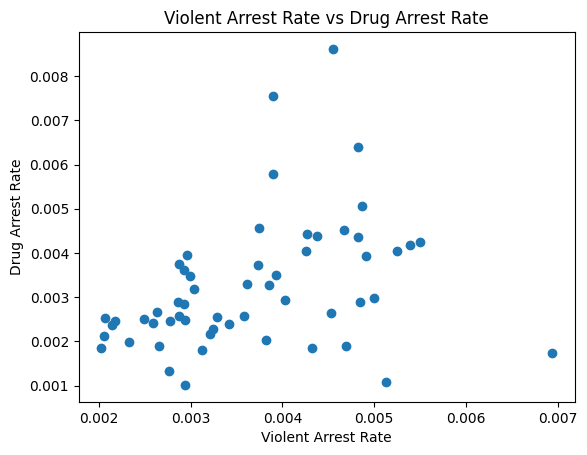

In [82]:
plt.scatter(violent_arrest_rate_2009, drug_arrest_rate_2009)
plt.xlabel("Violent Arrest Rate")
plt.ylabel("Drug Arrest Rate")
plt.title("Violent Arrest Rate vs Drug Arrest Rate")

### Exercise 14

Based on this simple comparison of 2009 violent arrest rates and drug arrest rates, what might you conclude about the relationship between the illegal drug trade and violent crime?

From this scatterplot, I am to determine a moderately positive relationship between Violent Arrest Rate and Drug Arrest Rate. Where if there is a higher number of violent arrests within the population we will also see higher number of drug arrest within each population of each county. 

## Comparing with 2018 Arrests

The preceding analysis can tell us about whether violent crime and the drug trade are correlated, but it doesn't tell us much about whether they are *causally* related. It *could* be the case that people dealing drugs *cause* more violent crime, but it could also be that certain communities, for some other reason, tend to have *both* more drug sales *and* more violent crime. 

To help answer this question, let's examine whether violent crime arrest rates changed in response to drug legalization. In particular, let's do this by comparing violent crime arrest rates in 2009 (before drug legalization) to violent crime arrest rates in 2018 (after drug legalization). If the illegal drug trade causes violent crime, then we would expect the violent crime rate to fall in response to drug legalization.


### Exercise 15

Just as we created violent arrest rates and drug arrest rates for 2009, now we want to do it for 2018. Using the data on 2018 arrests (also in the [same repository](https://github.com/nickeubank/practicaldatascience/tree/master/Example_Data/ca) we used before) and the same dataset of population data (you'll have to use population from 2013-2017, as 2018 population data has yet to be released), create a dataset of arrest rates. 

As before, *be careful with your merges!!!*

In [83]:
ca_2018_arrests = pd.read_csv(
    "https://raw.githubusercontent.com/nickeubank/practicaldatascience/master/Example_Data/ca/ca_arrests_2018.csv"
)
nhgis_df_cali_correct = nhgis_df_cali.copy()

nhgis_df_cali_2018 = nhgis_df_cali_correct[nhgis_df_cali_correct["YEAR"] == "2013-2017"]

merged_2018_df = pd.merge(
    ca_2018_arrests, nhgis_df_cali_2018, how="left", validate="1:m", indicator=True
)

merged_2018_df = merged_2018_df.reset_index(drop=True)
merged_2018_df.sample(5)

violent_arrest_rate_2018 = []
drug_arrest_rate_2018 = []
for index, row in merged_2018_df.iterrows():
    drug_arrest_rate_2018.append(row["F_DRUGOFF"] / row["total_population"])
    violent_arrest_rate_2018.append(row["VIOLENT"] / row["total_population"])

merged_2018_df["drug_arrest_rate_2018"] = drug_arrest_rate_2018
merged_2018_df["violent_arrest_rate_2018"] = violent_arrest_rate_2018

### Exercise 16

Now merge our two county-level datasets so you have one row for every county, and variables for violent arrest rates in 2018, violent arrest rates in 2009, felony drug arrest rates in 2018, and felony drug arrest rates in 2009. Store the number of observations in your final data set in your `results` dictionary under the key `"ex16_num_obs"`.

In [96]:
merged_2018_2009_df = pd.merge(merged_df, merged_2018_df, how="outer", on="COUNTY")
merged_2018_2009_df

,COUNTY,VIOLENT_x,PROPERTY_x,F_DRUGOFF_x,F_SEXOFF_x,F_ALLOTHER_x,F_TOTAL_x,M_TOTAL_x,S_TOTAL_x,YEAR_x,...,F_ALLOTHER_y,F_TOTAL_y,M_TOTAL_y,S_TOTAL_y,YEAR_y,STATE_y,total_population_y,_merge,drug_arrest_rate_2018,violent_arrest_rate_2018
0,Alameda County,4318,4640,5749,260,3502,18469,37247,431,2005-2009,...,2619,11037,28305,82,2013-2017,California,1629615.0,both,0.000652,0.002536
1,Alpine County,8,4,2,1,1,16,83,0,2005-2009,...,3,11,41,0,2013-2017,California,1203.0,both,0.000831,0.004156
2,Amador County,100,59,101,5,199,464,801,2,2005-2009,...,142,288,701,1,2013-2017,California,37306.0,both,0.000831,0.001930
3,Butte County,641,602,542,34,429,2248,9026,1,2005-2009,...,741,2239,8853,1,2013-2017,California,225207.0,both,0.001017,0.003486
4,Calaveras County,211,83,123,14,70,501,968,3,2005-2009,...,96,320,897,0,2013-2017,California,45057.0,both,0.000644,0.003263
5,Colusa County,58,50,28,7,132,275,917,0,2005-2009,...,126,236,753,0,2013-2017,California,21479.0,both,0.000233,0.003073
6,Contra Costa County,2976,3532,2895,189,2069,11661,18539,50,2005-2009,...,2489,8785,16223,2,2013-2017,California,1123678.0,both,0.000708,0.002326
7,Del Norte County,144,104,79,13,97,437,1268,5,NaN,...,89,355,1525,0,NaN,NaN,NaN,left_only,NaN,NaN
8,El Dorado County,570,399,403,45,614,2031,4734,54,2005-2009,...,459,1317,3508,0,2013-2017,California,185015.0,both,0.000551,0.002594
9,Fresno County,4377,3514,3508,305,3253,14957,31710,377,2005-2009,...,2899,9960,28736,38,2013-2017,California,971616.0,both,0.000571,0.004442


### Exercise 17

Did drug arrests go down from 2009 to 2018 in response to drug legalization? (they sure better! This is what's called a "sanity check" of your data and analysis. If you find drug arrests went *up*, you know something went wrong with your code or your understanding of the situations). 

Store the average county-level change in drug arrests per capita in `results` under the key `"ex17_drug_change"`.

### Exercise 18

Now we want to look at whether violent crime decreased following drug legalization. Did the average violent arrest rate decrease? By how much? (Note: We're assuming that arrest rates are proportionate to crime rates. If policing increased so that there were more arrests per crime committed, that would impact our interpretation of these results. But this is just an exercise, so...)

Store the average county-level change in violent arrests per capita in `results` under the key `"ex18_violent_change"`

### Exercise 19

Based on your answers to exercises 17 and 18, what might you conclude about the relationship between the illegal drug trade and violent crime? Did legalizing drugs increase violent crime (assuming arrest rates are a good proxy for crime rates)? Decrease violent crime? Have no effect? 

## Difference in Difference Analysis

The preceding analysis is something we sometimes call a "pre-post" analysis, in that it is a comparison of how and outcome we care about (violent arrest rates) changes from before a treatment is introduced ("pre") to after ("post"). BUT: pre-post comparisons are imperfect. If we knew that violent crime was not going to change at all in a world without drug legalization, then this comparison is perfectly valid. But what if, absent drug legalization, violent crime would have fallen on its own (maybe because of advances in policing practices or a better economy)? Or maybe it would have increased?

This is actually a very common problem. For example, imagine you're trying to figure out whether taking tylenol helps with headaches. You have a patient with a headache, you give them tylenol, and then the next day you ask them if they still have a headache, and find out that they don't — does that mean that tylenol cured the headache? Maybe... but most headaches eventually resolve on their own, so maybe the headache would have passed with or without the patient taking tylenol! In fact, there's a term for this phenomenon in medicine — the "natural history" of a disease, which is the trajectory that we think a disease might follow absent treatment. And the natural history of the disease is almost never for it to stay exactly the same indefinitely.

(All of this is closely related to the discipline of causal inference, and if it makes your head to hurt, don't worry — that means you're doing it right! We will talk lots and lots more about it in the weeks and months to come.)

One way to try to overcome this problem is with something called a difference-in-difference analysis. Rather than just looking at whether violent drug arrest rates increase or decrease between 2009 and 2018, we can split our sample of counties into those that were *more* impacted by drug legalization and those that were *less* impacted by drug legalization and evaluate whether we see a greater change in the violent drug arrest rate in the counties that were more impacted. 

What does it mean to have been "more impacted" by drug legalization? In this case, we can treat the counties that had higher drug arrest rates in 2009 as counties that were more impacted by drug legalization than those that had low drug arrest rates in 2009. After all, in a county that had no drug arrests, legalization wouldn't do anything, would it? 



### Exercise 20

First, split our sample into two groups: high drug arrests in 2009, and low drug arrests in 2009 (cut the sample at the average drug arrest rate in 2009). 



### Exercise 21

Now, determine weather violent crime changed *more* from 2009 to 2018 in the counties that had lots of drug arrests in 2009 (where legalization likely had more of an effect) than in counties with fewer drug arrests in 2009 (where legalization likely mattered less)? 

Calculate this difference-in-difference:

```
(the change in violent crime rate per capita for counties with lots of drug arrests in 2009) 
- (the change in violent crime rate per capita for counties with few drug arrests in 2009)

```

Store your "difference-in-difference" estimate in your `results` dictionary under the key `"ex21_diffindiff"`.

### Exercise 22

Interpret your difference in difference result.

### Exercise 23

The quantity we estimated above is a little difficult to interpret. Rather than calculating the *absolute* change in violent arrest rates per capita, let's calculate the *proportionate* change.

Calculate:

```
(the county-level percentage change in violent crime rate with lots of drug arrests in 2009) 
- (the county-level percentage change in violent crime rate with few drug arrests in 2009)
```
Store your "difference-in-difference" estimate in your `results` dictionary under the key `"ex24_diffindiff_proportionate"`. Report your result in percentages, such that a value of `-100` would imply that the average county experienced a 100% decrease in the violent arrest rate.